In [1]:
# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

import xgboost as xgb  #GBM algorithm
from xgboost import XGBRegressor
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   # Perforing grid search

from IPython.display import display

# remove warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_csv('data/new_train.csv')
test_data = pd.read_csv('data/new_test.csv')

print train_data.shape
display(train_data.head(1))
# display(train_data.info())

print test_data.shape
display(test_data.head(1))
# display(test_data.info())
train_length = train_data.shape[0]

(1460, 270)


,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LandSlope,OverallQual,OverallCond,...,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Id,SalePrice
0,0.140357,0.032874,0.693147,0.0,0.693147,0.693147,0.693147,0.693147,0.510826,0.405465,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,12.247699


(1459, 269)


,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LandSlope,OverallQual,OverallCond,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Id
0,0.184032,0.047118,0.693147,0.0,0.693147,0.693147,0.693147,0.693147,0.367725,0.485508,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1461


In [3]:
def float_range(start,stop,nums):
    ''' Computes a range of floating value.
        
        Input:
            start (float)  : Start value.
            end   (float)  : End value
            nums (integer): Number of values
        
        Output:
            A list of floats
    '''
    return [start+float(i)*(stop-start)/(float(nums)-1) for i in range(nums)]

In [4]:
train_id = train_data['Id']
train_Y = train_data['SalePrice']
train_data.drop(['Id', 'SalePrice'], axis=1, inplace=True)
train_X = train_data

test_id = test_data['Id']
test_data.drop('Id', axis=1, inplace=True)
test_X = test_data

In [5]:
# formatting for xgb
dtrain = xgb.DMatrix(train_X, label=train_Y)
dtest = xgb.DMatrix(test_X)

# XGBoost  & Parameter Tuning

Ref: [Complete Guide to Parameter Tuning in XGBoost](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

## Parameters Tuning Plan

The overall parameters can be divided into 3 categories:

1. General Parameters: Guide the overall functioning
2. Booster Parameters: Guide the individual booster (tree/regression) at each step
3. Learning Task Parameters: Guide the optimization performed

In `XGBRegressor`:
```
class xgboost.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='reg:linear', nthread=-1, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, seed=0, missing=None)
```

In [6]:
def model_cross_validate(xgb_regressor, cv_paramters, dtrain, 
              cv_folds = 5, early_stopping_rounds = 50, perform_progress=False):
    """
    xgb model cross validate to choose best param from giving cv_paramters.
    
    @param cv_paramters:dict,where to choose best param. {'param':[1,2,3]}
    @param dtrain:xgboost.DMatrix, training data formatted for xgb
    @param early_stopping_rounds: Activates early stopping.Stop when perfomance 
                                  does not improve for some rounds
    """
    # get initial parameters
    xgb_param = xgb_regressor.get_xgb_params()
    
    # save best param
    best_param = {}
    best_cvresult = None
    min_mean_rmse = float("inf")
    
    for param, values in cv_paramters.items():
        print '===========Tuning paramter:',param,'==========='
        for value in values:
            # set the param's value
            xgb_param[param] = value
            
            # cv to tune param from values
            cvresult = xgb.cv(xgb_param, dtrain, num_boost_round=xgb_param['n_estimators'], 
                              nfold=cv_folds, metrics='rmse', 
                              early_stopping_rounds=early_stopping_rounds)

            # calcuate the mean of several final rmses
            round_count = cvresult.shape[0]
            mean_rmse = cvresult.loc[round_count-4:round_count-1,'test-rmse-mean'].mean()
            
            if perform_progress:
                std_rmse = cvresult.loc[round_count-4:round_count-1,'test-rmse-std'].mean()

                if isinstance(value, int):
                    print "%s=%d CV RMSE : Mean = %.7g | Std = %.7g" % (param, value, mean_rmse, std_rmse)
                else:
                    print "%s=%f CV RMSE : Mean = %.7g | Std = %.7g" % (param, value, mean_rmse, std_rmse)

            if mean_rmse < min_mean_rmse:
                best_param[param] = value
                best_cvresult = cvresult
                min_mean_rmse = mean_rmse
        
        print "best ", param, " = ", best_param[param]
    
    return best_param, min_mean_rmse, best_cvresult


In [7]:
def model_fit(regressor, train_x, train_y, performCV=True, 
              printFeatureImportance=True, cv_folds=5):
    
    # fir the train data
    regressor.fit(train_x, train_y)
    
    # Predict training set
    train_predictions = regressor.predict(train_x)
    mse = metrics.mean_absolute_error(train_y, regressor.predict(train_x))
    print "Model training report:"
    print("MSE: %.9f" % mse)
    
    # Perform cross-validation
    if performCV:
        cv_score = cross_validation.cross_val_score(regressor, train_x, train_y, 
                                               cv=cv_folds, scoring='r2')
        print "CV Score : Mean = %.7g | Std = %.7g | Min = %.7g | Max = %.7g" % \
                (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
    
    # Print Feature Importance
    if printFeatureImportance:
        feature_importances = pd.Series(regressor.feature_importances_, train_x.columns.values)
        feature_importances = feature_importances.sort_values(ascending=False)
        feature_importances= feature_importances.head(40)
        feature_importances.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
    
    return regressor, feature_importances

Baseline XGBRegressor

Model training report:
MSE: 0.060791989
CV Score : Mean = 0.9066177 | Std = 0.006345624 | Min = 0.9009837 | Max = 0.9179538


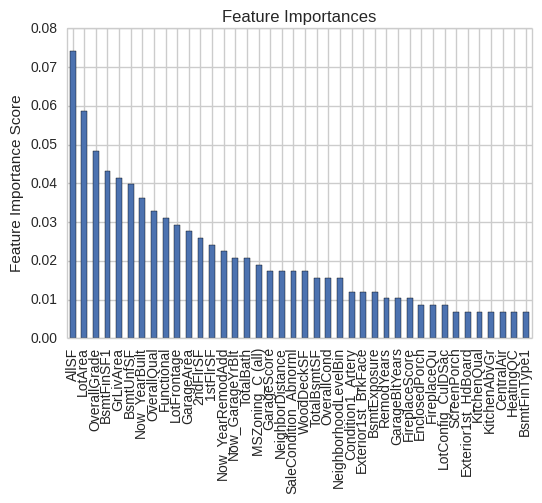

In [8]:
xgb_regressor = XGBRegressor(seed=10)
xgb_regressor, feature_importances = model_fit(xgb_regressor,train_X, train_Y)

### 1. Choose a relatively high learning_rate,optimum n_estimators

In [9]:
param_test1 = {'n_estimators':range(180,220,10)}

xgb_regressor = XGBRegressor(
                learning_rate =0.1,
    
                max_depth=5,
                min_child_weight=1,
                gamma=0,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

best_param, min_mean_rmse, best_cvresult = \
                model_cross_validate(xgb_regressor, param_test1, dtrain)

print 'best params:', best_param
print 'min_mean_rmse:', min_mean_rmse

===========Tuning paramter: n_estimators ===========
best  n_estimators  =  190
best params: {'n_estimators': 190}
min_mean_rmse: 0.12232155


Model training report:
MSE: 0.023148245
CV Score : Mean = 0.9079074 | Std = 0.01018442 | Min = 0.8935438 | Max = 0.9253455


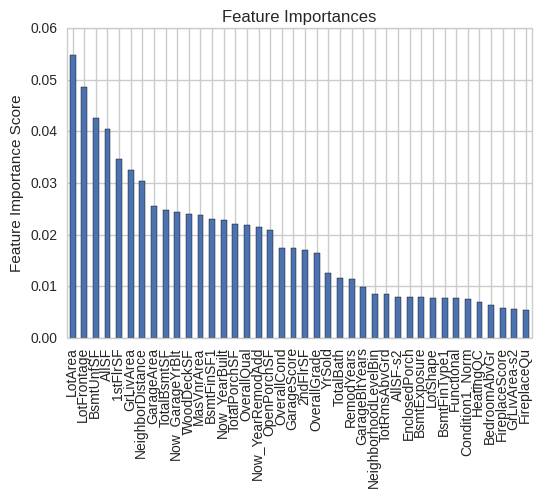

In [10]:
xgb_regressor = XGBRegressor(
                learning_rate=0.1,
                n_estimators=190,
    
                max_depth=5,
                min_child_weight=1,
                gamma=0,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

xgb_regressor, feature_importances = model_fit(xgb_regressor,train_X, train_Y)

### 2.Fix learning rate and number of estimators for tuning tree-based parameters

Tune `max_depth` and `min_child_weight`

In [22]:
param_test2 = {'max_depth':range(1,6,1),
               'min_child_weight':range(1,8,1)}

xgb_regressor = XGBRegressor(
                learning_rate=0.1,
                n_estimators=190,
    
                gamma=0,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

best_param, min_mean_rmse, best_cvresult = \
                model_cross_validate(xgb_regressor, param_test2, dtrain, perform_progress=True)

print 'best params:', best_param
print 'min_mean_rmse:', min_mean_rmse

===========Tuning paramter: max_depth ===========
max_depth=1 CV RMSE : Mean = 0.1308934 | Std = 0.01763976
max_depth=2 CV RMSE : Mean = 0.1209244 | Std = 0.01931434
max_depth=3 CV RMSE : Mean = 0.1192104 | Std = 0.01819482
max_depth=4 CV RMSE : Mean = 0.122842 | Std = 0.0165105
max_depth=5 CV RMSE : Mean = 0.1223215 | Std = 0.01838523
best  max_depth  =  3
===========Tuning paramter: min_child_weight ===========
min_child_weight=1 CV RMSE : Mean = 0.1223215 | Std = 0.01838523
min_child_weight=2 CV RMSE : Mean = 0.1187617 | Std = 0.01713328
min_child_weight=3 CV RMSE : Mean = 0.1202518 | Std = 0.01869515
min_child_weight=4 CV RMSE : Mean = 0.1194034 | Std = 0.0181364
min_child_weight=5 CV RMSE : Mean = 0.1190324 | Std = 0.0186584
min_child_weight=6 CV RMSE : Mean = 0.1214874 | Std = 0.01895751
min_child_weight=7 CV RMSE : Mean = 0.1210811 | Std = 0.01957277
best  min_child_weight  =  2
best params: {'max_depth': 3, 'min_child_weight': 2}
min_mean_rmse: 0.1187617


Model training report:
MSE: 0.049354909
CV Score : Mean = 0.913248 | Std = 0.00767333 | Min = 0.9062061 | Max = 0.9280594


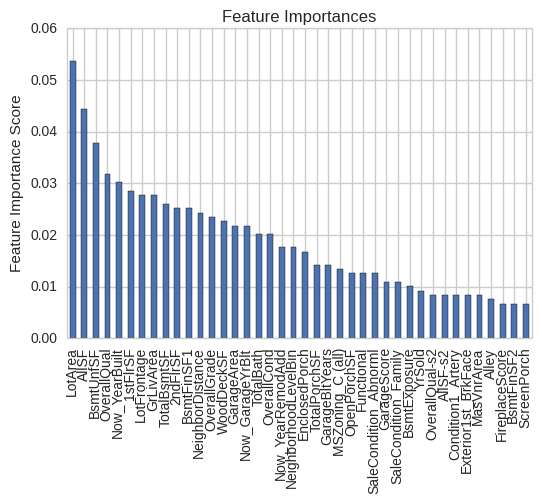

In [23]:
xgb_regressor = XGBRegressor(
                learning_rate=0.1,
                n_estimators=190,
                max_depth=3,
                min_child_weight=2,
    
                gamma=0,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

xgb_regressor, feature_importances = model_fit(xgb_regressor,train_X, train_Y)